In [1]:
%matplotlib inline

#%matplotlib 
#import matplotlib.pyplot as plt
#plt.ion()

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set_style('darkgrid')
import scipy
from scipy import special as s
import numpy
import math
import time

from mpl_toolkits.mplot3d import Axes3D

In [4]:
cwd = os.getcwd()
NOTEBOOK_DIR = os.path.dirname(cwd+'/')
ROOT = os.path.dirname(NOTEBOOK_DIR)

import sys
sys.path.append(ROOT)

In [5]:
from utils.plot import *
from utils.tools import *
from utils.nn import TARGET_FUNCS_DICT, LOSS_DICT
from networks import two_layer_net

## Constants

In [6]:
n_samples = 500
input_dim = 20
d_H = 5
width = 1024  # 1024
bias = False
n_steps = 5000
base_lr = 5e-2
batch_size = 256

SEED = 42
pause = 1e-6

In [7]:
FIGURES_DIR = os.path.join(ROOT, 'figures/2-layer/high_dim/bias/{}'.format(width))

In [8]:
set_random_seeds(SEED)

## Data

In [9]:
# val data
X_val = torch.randn(size=(n_samples, input_dim), requires_grad=False)
all_Xs = torch.randn(size=(n_steps * batch_size, input_dim), requires_grad=False)

# loss 
loss = LOSS_DICT['mse'](reduction='mean')

In [10]:
def legendre(k, d, t):
    max_j = math.floor(k/2)
    legendre_terms = np.array([((-1) ** j) * ((1 - (t**2)) ** j) * (t ** (k-2*j)) / \
         ((4 ** j) * s.factorial(j) * s.factorial(k - 2*j) * s.gamma(j + (d-1)/2)) \
         for j in range(max_j + 1)])
    sum_j = np.sum(legendre_terms, axis=0)
    return s.factorial(k) * s.gamma((d-1)/2) * sum_j

### 1. Spherical harmonics of degree 2 (zero mean)

In [11]:
network = two_layer_net.TwoLayerNet(input_dim=input_dim, width=width, bias=bias)
network.train()
optimizer = torch.optim.SGD(network.parameters(), lr=width * base_lr)

In [12]:
k = 2
with torch.no_grad():
    X_val_np = X_val[:, :d_H].detach().numpy()
    y_val_np = np.sum(legendre(k=k, d=input_dim, t=X_val_np), axis=1)
    y_val = torch.reshape(torch.Tensor(y_val_np), (len(X_val), 1))
    
    all_Xs_np = all_Xs[:, :d_H].detach().numpy()
    all_ys_np = np.sum(legendre(k=k, d=input_dim, t=all_Xs_np), axis=1)
    all_ys = torch.reshape(torch.Tensor(all_ys_np), (len(all_Xs_np), 1))

In [13]:
train_losses = []
val_losses = []

for i in range(n_steps):
    optimizer.zero_grad()
    X = all_Xs[i * batch_size: (i+1) * batch_size, :]
    y = all_ys[i * batch_size: (i+1) * batch_size, :]

    # forward
    y_hat = network.forward(X)
    loss_ = 0.5 * ((y_hat - y) ** 2).mean()
        
    if i == 0:
        with torch.no_grad():
            loss_0 = loss_.detach().item()
    loss_ = loss_ / loss_0

    # backward and gradient step
    loss_.backward()
    optimizer.step()
    train_losses.append(loss_.detach().item())

    # val
    with torch.no_grad():
        y_hat_val = network.forward(X_val)
        val_loss = 0.5 * ((y_hat_val - y_val) ** 2).mean() / loss_0
        val_losses.append(val_loss.detach().item())

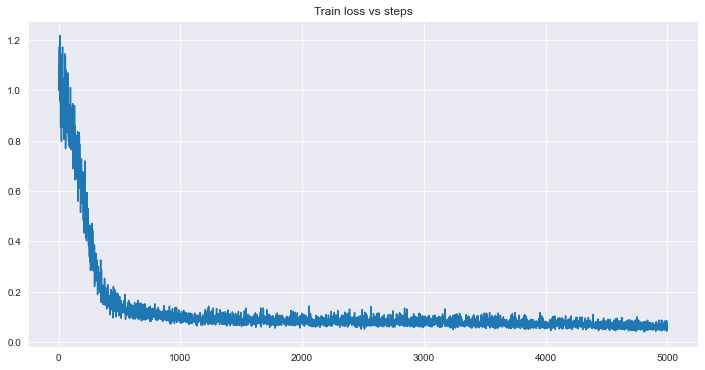

In [14]:
figure = plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(train_losses)), train_losses)
plt.title('Train loss vs steps')
plt.show()

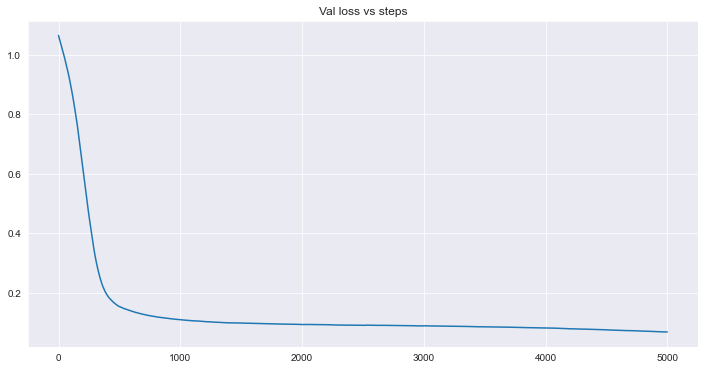

In [15]:
figure = plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(val_losses)), val_losses)
plt.title('Val loss vs steps')
plt.show()

### 2. Spherical harmonics of degree 0 and 2 (mean not 0)

In [16]:
network = two_layer_net.TwoLayerNet(input_dim=input_dim, width=width, bias=bias)
network.train()
optimizer = torch.optim.SGD(network.parameters(), lr=width * base_lr)

In [17]:
with torch.no_grad():
    y_val = torch.reshape((X_val[:, :d_H] ** 2).sum(dim=1), (len(X_val), 1))
    all_ys = torch.reshape((all_Xs[:, :d_H] ** 2).sum(dim=1), (len(all_Xs), 1))

In [18]:
train_losses = []
val_losses = []

for i in range(n_steps):
    optimizer.zero_grad()
    X = all_Xs[i * batch_size: (i+1) * batch_size, :]
    y = all_ys[i * batch_size: (i+1) * batch_size, :]

    # forward
    y_hat = network.forward(X)
    loss_ = 0.5 * ((y_hat - y) ** 2).mean()
        
    if i == 0:
        with torch.no_grad():
            loss_0 = loss_.detach().item()
    loss_ = loss_ / loss_0

    # backward and gradient step
    loss_.backward()
    optimizer.step()
    train_losses.append(loss_.detach().item())

    # val
    with torch.no_grad():
        y_hat_val = network.forward(X_val)
        val_loss = 0.5 * ((y_hat_val - y_val) ** 2).mean()
        val_losses.append(val_loss.detach().item())

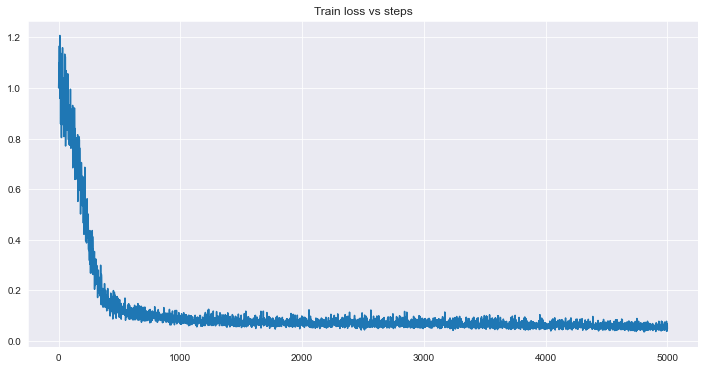

In [19]:
figure = plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(train_losses)), train_losses)
plt.title('Train loss vs steps')
plt.show()

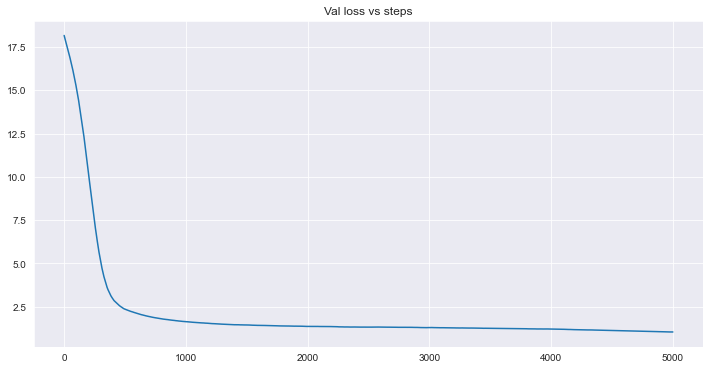

In [20]:
figure = plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(val_losses)), val_losses)
plt.title('Val loss vs steps')
plt.show()

### 3. Spherical harmonics of degree 4 (zero-mean)

In [21]:
network = two_layer_net.TwoLayerNet(input_dim=input_dim, width=width, bias=bias)
network.train()
optimizer = torch.optim.SGD(network.parameters(), lr=width * base_lr)

In [22]:
k = 4
with torch.no_grad():
    X_val_np = X_val[:, :d_H].detach().numpy()
    y_val_np = np.sum(legendre(k=k, d=input_dim, t=X_val_np), axis=1)
    y_val = torch.reshape(torch.Tensor(y_val_np), (len(X_val), 1))
    
    all_Xs_np = all_Xs[:, :d_H].detach().numpy()
    all_ys_np = np.sum(legendre(k=k, d=input_dim, t=all_Xs_np), axis=1)
    all_ys = torch.reshape(torch.Tensor(all_ys_np), (len(all_Xs_np), 1))

In [23]:
train_losses = []
val_losses = []

for i in range(n_steps):
    optimizer.zero_grad()
    X = all_Xs[i * batch_size: (i+1) * batch_size, :]
    y = all_ys[i * batch_size: (i+1) * batch_size, :]

    # forward
    y_hat = network.forward(X)
    loss_ = 0.5 * ((y_hat - y) ** 2).mean() / 50

    # backward and gradient step
    loss_.backward()
    optimizer.step()
    train_losses.append(loss_.detach().item())

    # val
    with torch.no_grad():
        y_hat_val = network.forward(X_val)
        val_loss = 0.5 * ((y_hat_val - y_val) ** 2).mean() / 50
        val_losses.append(val_loss.detach().item())

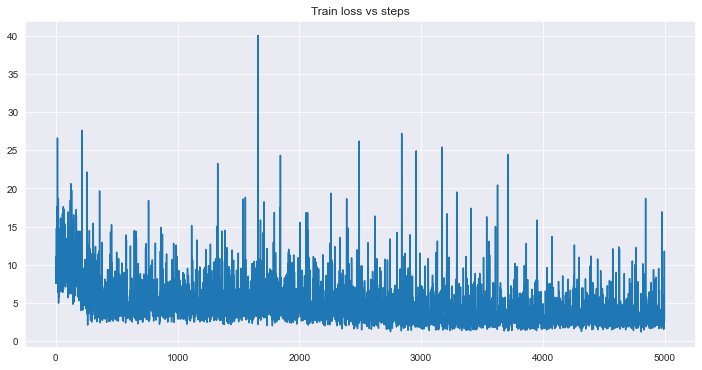

In [24]:
figure = plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(train_losses)), train_losses)
plt.title('Train loss vs steps')
plt.show()

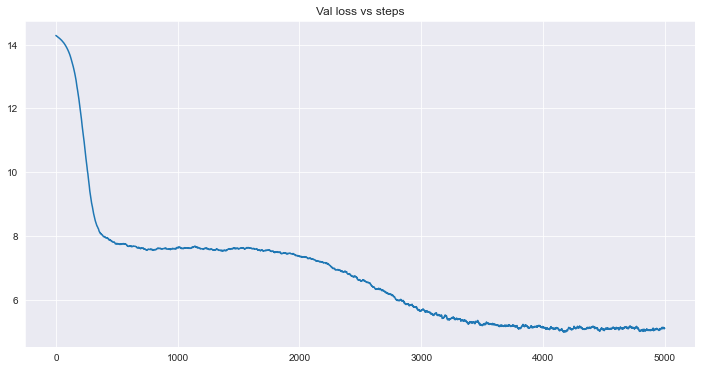

In [25]:
figure = plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(val_losses)), val_losses)
plt.title('Val loss vs steps')
plt.show()

### 3. Spherical harmonics of degree 6 (zero-mean)

In [46]:
base_lr = 1e-2
network = two_layer_net.TwoLayerNet(input_dim=input_dim, width=width, bias=bias)
network.train()
optimizer = torch.optim.SGD(network.parameters(), lr=width * base_lr)

In [47]:
k = 6
with torch.no_grad():
    X_val_np = X_val[:, :d_H].detach().numpy()
    y_val_np = np.sum(legendre(k=k, d=input_dim, t=X_val_np), axis=1)
    y_val = torch.reshape(torch.Tensor(y_val_np), (len(X_val), 1))
    
    all_Xs_np = all_Xs[:, :d_H].detach().numpy()
    all_ys_np = np.sum(legendre(k=k, d=input_dim, t=all_Xs_np), axis=1)
    all_ys = torch.reshape(torch.Tensor(all_ys_np), (len(all_Xs_np), 1))

In [48]:
train_losses = []
val_losses = []

for i in range(n_steps):
    optimizer.zero_grad()
    X = all_Xs[i * batch_size: (i+1) * batch_size, :]
    y = all_ys[i * batch_size: (i+1) * batch_size, :]

    # forward
    y_hat = network.forward(X)
    loss_ = 0.5 * ((y_hat - y) ** 2).mean() / 10000

    # backward and gradient step
    loss_.backward()
    optimizer.step()
    train_losses.append(loss_.detach().item())

    # val
    with torch.no_grad():
        y_hat_val = network.forward(X_val)
        val_loss = 0.5 * ((y_hat_val - y_val) ** 2).mean() / 10000
        val_losses.append(val_loss.detach().item())

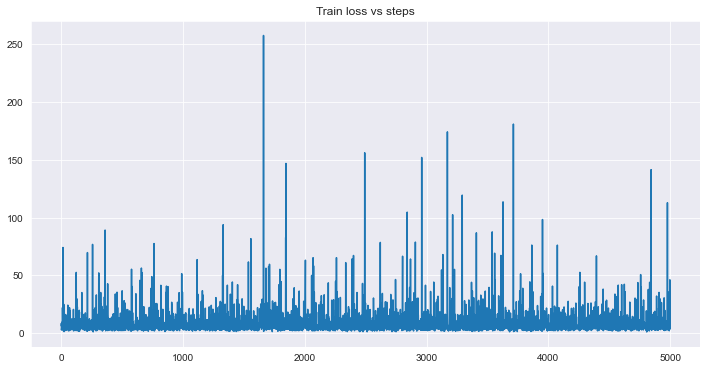

In [49]:
figure = plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(train_losses)), train_losses)
plt.title('Train loss vs steps')
plt.show()

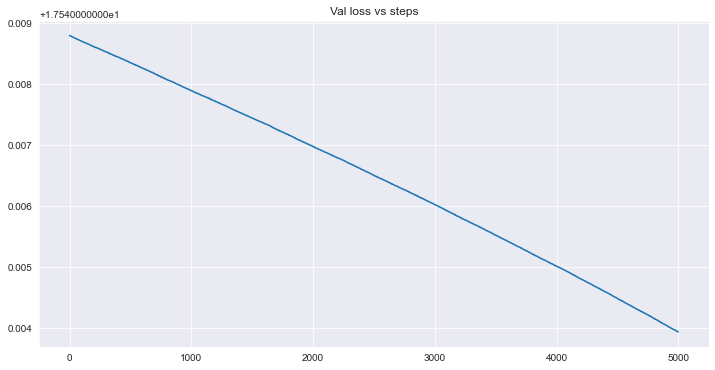

In [50]:
figure = plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(val_losses)), val_losses)
plt.title('Val loss vs steps')
plt.show()

## Quizz

In [62]:
def B_1(x):
    return np.exp(-5*x) * (3*x - 42/5) + 7
print(B_1(0), B_1(3), B_1(5))

-1.4000000000000004 7.000000183541392 7.00000000009166


In [63]:
def B_2(x):
    return np.exp(-3*x) * (2*x - 22/3) + 4
print(B_2(0), B_2(4), B_2(6))

-3.333333333333333 4.000004096141569 4.000000071073239


# TD3-4

In [6]:
(np.exp(5) + 1) / 7

21.3447370146538

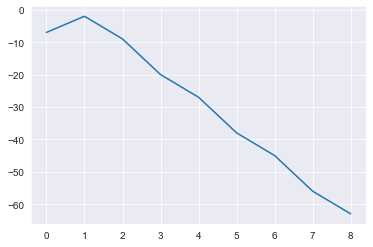

In [7]:
plt.plot(np.arange(9), [-x^2 + 8*x - 9 for x in np.arange(9)])

In [25]:
## EXO5 - TD3
delta = (10.8 ** 2) + 4 * 0.012 * 1200
delta

174.24

In [30]:
x_pos = (-10.8 + np.sqrt(delta)) / (2 * 0.012)
x_pos

100.00000000000001

In [32]:
1700 - 14 * x_pos

299.9999999999998

In [33]:
500 - 3.2 * x_pos + 0.012 * (x_pos ** 2)

300.0

In [14]:
1.6*2

3.2

In [15]:
0.004*3

0.012

In [31]:
np.roots([0.012, 10.8, -1200])

array([-1000.,   100.])

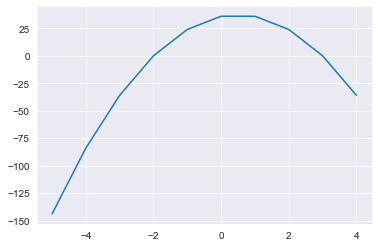

In [35]:
plt.plot(np.arange(-5, 5), [36+6*x-6*(x**2) for x in np.arange(-5, 5)])

In [36]:
36 * (-2) + 3*(2**2) - 2 * ((-2)**3)

-44

In [37]:
36 * (3) + 3*(2**2) - 2 * ((3)**3)

66